In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import importlib
plt.style.use('dark_background')

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 4, 2

In [3]:
sys.path.insert(0, '../seqm') 

In [4]:
# setting path
import model_pipe
import models
import generators
import dataset     
import post_process      

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 39.33it/s]


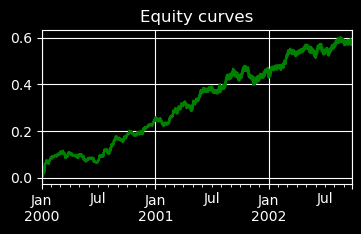

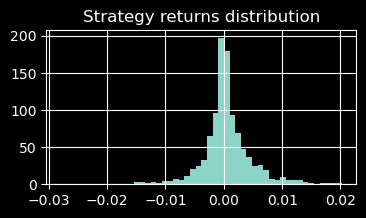

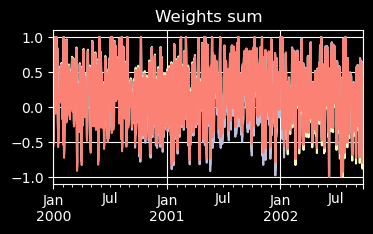

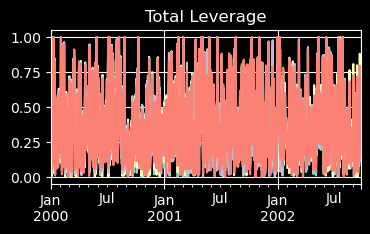


** ACCEPT STRATEGY **


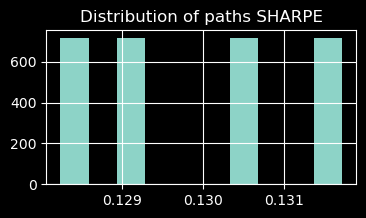

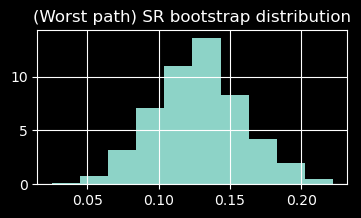


** PERFORMANCE SUMMARY **

Return:  0.0005774430983366496
Standard deviation:  0.0044442968623567185
Sharpe:  0.12992901154457162



In [5]:
# Conditional Gaussian/Mixture
# data now contains observed states, for example model for different weekdays
phi=np.array([0.8,0.2])
means=[
        np.array([0.1]),
        np.array([-0.1])
    ] # let the means be different from zero 
# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.1]]),
    np.array([[0.5]])
]
# number of data points to generate
n=500 
data=generators.linear(n=1000,a=0,b=0.1,start_date='2000-01-01')

dataset_obj=dataset.Dataset({'dataset 1':data})	
# create model
model=models.ConditionalGaussian(n_gibbs=None,kelly_std=2,max_w=1)
model_pipes=model_pipe.ModelPipes(model)
for key in dataset_obj.keys():
    model_pipe_ = model_pipe.ModelPipe()
    model_pipes[key] = model_pipe_

paths=dataset_obj.cvbt(
                model_pipes, 
                k_folds=4, 
                seq_path=False, 
                start_fold=0, 
                n_paths=4, 
                burn_fraction=0.1, 
                min_burn_points=3, 
                share_model=True, 
                view_models=False
                )
post_process.post_process(paths)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


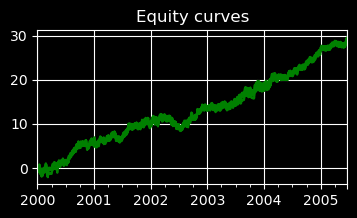

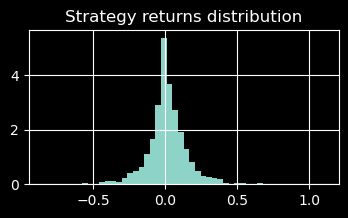

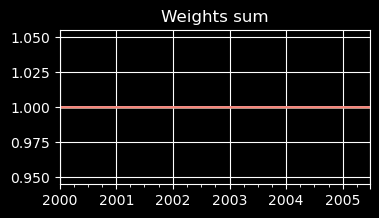

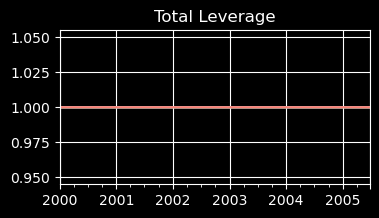

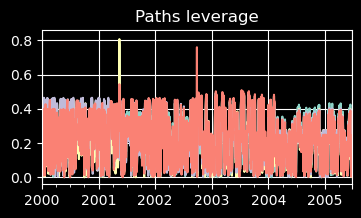

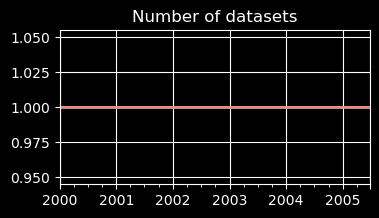


** ACCEPT STRATEGY **


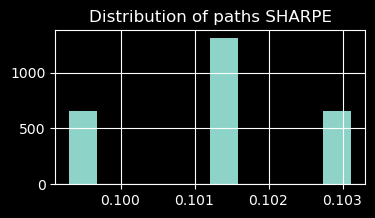

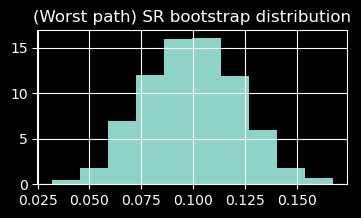


** PERFORMANCE SUMMARY **

Return:  0.014656988216827592
Standard deviation:  0.14479794172533397
Sharpe:  0.10122373317039488



In [8]:
# HMM
# simple HMM 
# simulate and fit
A=np.array([
            [0.9,0.1],
            [0.1,0.9]
        ]) # state transition

P=np.array([0.5,0.5]) # initial state distribution

means=[
        np.array([0.1]),
        np.array([-0.1])
    ] # let the means be different from zero 

# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.1]]),
    np.array([[0.5]])
]
# number of data points to generate
n=2000 
x,z=generators.simulate_hmm(n,A,P,means,covs)

dates=pd.date_range('2000-01-01',periods=n,freq='D')
data=pd.DataFrame(x,columns=['y1'],index=dates)

dataset_obj=dataset.Dataset({'dataset 1':data})	
# create model
model=models.GaussianHMM(n_states=2,n_gibbs=100,kelly_std=2,max_w=1)
model_pipes=model_pipe.ModelPipes(model)
for key in dataset_obj.keys():
    model_pipe_ = model_pipe.ModelPipe()
    model_pipes[key] = model_pipe_

paths=dataset_obj.cvbt(
                model_pipes, 
                k_folds=4, 
                seq_path=False, 
                start_fold=0, 
                n_paths=4, 
                burn_fraction=0.1, 
                min_burn_points=3, 
                share_model=True, 
                view_models=False
                )
post_process.portfolio_post_process(paths)